# Premiere Partie : le modèle simple 

On cherche ici à réaliser le modèle le plus simple possible.

* On prend une population de n individus.
* Ces individus sont connectés les uns aux autres par des liens, en réseau, générés de façon aléatoire, selon diverses distributions.
* Parmi ces n individus, un pourcentage p est touché par une maladie.
* La probabilité d'être touché par cette malade est d'une probabilité $\lambda$
* Certains individus sont immunisés contre la maladie (par un vaccin), avec une probabilité $\mu$.
* La probabilité de guérir sans la vaccin est de $\eta$.
* On suppose que, quand on est vacciné, la probabilité de tomber malade est de 0.

Ces hypothèses seront par la suite assouplies

Le temps t sera défini par l'utilisateur

In [1]:
import networkx as nx
import math as math
import random as rd
import numpy as np
import scipy.stats as scstat
import matplotlib as plot
import matplotlib.pyplot as plt

## Implémentation du réseau

Dans cette partie, nous mettons en place un réseau généré aléatoirement par une fonction gaussienne. Les paramètres pourront être modifiés par les utilisateurs du logiciel.


Choses à faire pour que le modèle soit dynamique :


* Créer de nouveaux graphes, plus en lien avec ce que l'on veut faire.
* Mettre tout ce qu'on a fait précédemment sous la forme d'arguments.


### Mise en place d'attributs

In [91]:
#Caractéristiques initiales de la maladie

p_init = float(input ('Pourcentage initial de personnes contaminées : '))
lmbda = float(input('Contagiosité de la maladie : '))
mu = float(input('Poucentage de personnes vaccinées initialement : ')) 
eta = float(input('Probabilité que la personne guérisse sans vaccin : '))
rho = float(input('Probabilité de deces suite a la maladie : '))

if (eta + rho) > 1:
    print("Erreur : la somme de la probabilité de guérir et de la probabilité de mourir ne peut pas dépasser 1.")
    
#Premier paramètre : nombre de noeuds
#Deuxième paramètre : la moyenne de la taille des clusters
#Troisième paramètre : paramètre de taille, la variance de la taille des clusters vaut : moyenne de la taille / ce paramètre
#Quatrième paramètre : La probabilité de créer des liens au sein des clusters
#Cinquième paramètre : La probabilité de créer des liens entre les clusters

Pourcentage initial de personnes contaminées : 0.02
Contagiosité de la maladie : 0.5


KeyboardInterrupt: 

In [90]:
#Création du réseau d'individus

G2 = nx.Graph()
G2.clear()

n = int(input('Taille de la population : ')) # 1000 ?
m = float(input ('Moyenne de la taille d un cluster : ')) # 30 ?
p_intra = float(input ('Probabilité de créer des liens au sein des clusters : ')) # 0.3 ?
p_inter = float(input('Probabilité de créer des liens entre les clusters : ')) # 0.0002 ?
v = float(input('Paramètre de taille (variance) : ')) # 500 ?

G2 = nx.gaussian_random_partition_graph(n,m,v,p_intra,p_inter)
pos2 = nx.spring_layout(G2)

Taille de la population : 1000
Moyenne de la taille d un cluster : 30
Probabilité de créer des liens au sein des clusters : 0.4
Probabilité de créer des liens entre les clusters : 0.0002
Paramètre de taille (variance) : 500


In [83]:
G3 = nx.Graph.copy(G2)

In [84]:
#Mise en place des attributs pour chaque noeud (malade/pas malade initialement, vacciné/pas vacciné)
#Trouver un moyen de faire en sorte qu'on ne soit pas malade et contaminé en même temps

Populations = {k: {'malade': np.random.choice(["Oui", "Non"], p=[p_init, 1-p_init]), 'vacciné': np.random.choice(["Oui", "Non"], p=[mu, 1-mu]),'temps malade': 0} for k in range(n)}

# Je crois avoir compris le problème du graphique et pourquoi toute la population est saine au temps 1 :
    # Le critère pour être sain c'est avoir 'temps malade' = 0, or au temps 1 tout le monde a 'temps malade' = 1
    # Il faut donc changer Populations et mettre 'temps malade' = 1 pour les individus malades au moment initial.
    
# Pour que les malades à l'origine ait 'temps malade' = 1 dès le début du processus"
for k in range(n):
    if Populations[k]['malade'] == 'Oui':
        Populations[k]['temps malade'] += 1
#Fin de la modification

#print(Populations)


In [85]:
nx.set_node_attributes(G3,Populations)
# Necessité de mettre à jour Networkx

In [86]:
# Première étape : vérification de la commande

#Transmission de la maladie
def transmission_maladie (G, lmbda):
    for lien in G.edges(): # G.edges est l'ensemble des relations entre deux noeuds. 
        if (G.nodes[lien[0]]['malade'] == 'Oui') & (G.nodes[lien[1]]['malade'] == 'Non'): 
            if G.nodes[lien[1]]['vacciné'] == 'Non':
                G.nodes[lien[1]]['malade'] = np.random.choice(['Oui', 'Non'], p=[lmbda, 1-lmbda])
        elif (G.nodes[lien[0]]['malade'] == 'Non') & (G.nodes[lien[1]]['malade'] == 'Oui'):
            if G.nodes[lien[0]]['vacciné'] == 'Non':
                G.nodes[lien[0]]['malade'] = np.random.choice(['Oui', 'Non'], p=[lmbda, 1-lmbda])
# lien[0] est le 1er individu dans la relation et lien[1] le deuxième

# Guérir de la malade
def guerison_maladie (G, eta, Pop_retablie):
    sante = nx.get_node_attributes(G, 'malade') 
    for noeud in [k for k,v in sante.items() if v == 'Oui']:
        if G.nodes[noeud]['temps malade'] != 0:
            G.nodes[noeud]['malade'] = np.random.choice(['Oui', 'Non'], p=[1-eta, eta])
            if G.nodes[noeud]['malade'] == 'Non':
                G.nodes[noeud]['vacciné'] = 'Oui'
    sante2 = nx.get_node_attributes(G, 'malade') 
    Pop_retablie.append(len([k for k,v in sante2.items() if v == 'Non'])-len([k for k,v in sante.items() if v == 'Non']))
                        
# Mourir de la maladie                 
def deces (G,rho,Pop_tot):
    convalescence = nx.get_node_attributes(G, 'temps malade') 
    convalescence2 = nx.get_node_attributes(G, 'malade') # Pour régler le pb ci-dessous
    for noeud in [k for k,v in convalescence.items() if v != 0]: # Pb : ça tue tout ceux qui ont été malade même s'ils sont rétab
        if convalescence2[noeud] == 'Oui': # Pour régler le pb ci-dessus
            l = int(np.random.binomial(1,rho))
            if l == 1:
                G.remove_node(noeud)
    Pop_tot.append(len(G.nodes()))

# FONCTION PROBABILITE (meilleure)   
def deces_guerison (G, eta, Pop_retablie,rho,Pop_tot):
    sante = nx.get_node_attributes(G, 'malade')
    convalescence = nx.get_node_attributes(G, 'temps malade')
    elements = [0, 1, 2] #guérir = 0, mourir = 1, rester malade = 2
    probabilities = [eta, rho, 1-(eta+rho)]
    for noeud in [k for k,v in sante.items() if v == 'Oui']:
        if G.nodes[noeud]['temps malade'] != 0:
            l = np.random.choice(elements, 1, p=list(probabilities))
            if l == 0:
                G.nodes[noeud]['malade'] = 'Non'
                G.nodes[noeud]['vacciné'] = 'Oui'
            elif l == 1:
                G.remove_node(noeud)
    Pop_tot.append(len(G.nodes()))
    sante2 = nx.get_node_attributes(G, 'malade') 
    Pop_retablie.append(len([k for k,v in sante2.items() if v == 'Non'])-len([k for k,v in sante.items() if v == 'Non']))
                
# Mise à jour du temps passé malade

def temps_malade (G, Pop_malade_t,Pop_saine):
    sante = nx.get_node_attributes(G, 'malade') 
    convalescence = nx.get_node_attributes(G, 'temps malade') 
    for noeud in [k for k,v in sante.items() if v == 'Oui']:
        G.nodes[noeud]['temps malade'] += 1    
    Pop_malade_t.append(len([k for k,v in sante.items() if v == 'Oui']))
    convalescence2 = nx.get_node_attributes(G, 'temps malade') 
    Pop_saine.append(len(G.nodes())-len([k for k,v in convalescence2.items() if v != 0]))

In [79]:
def representation_reseau(G, pos):

    # Création des listes de noeuds
    Noeuds_malades = [k for k,v in nx.get_node_attributes(G, 'malade').items() if v == 'Oui']
    Noeuds_sains = [k for k,v in nx.get_node_attributes(G, 'malade').items() if v == 'Non']
    #Noeuds_vaccines = [k for k,v in nx.get_node_attributes(G3, 'vacciné').items() if v == 'Oui']
    #Noeuds_pas_vaccines = [k for k,v in nx.get_node_attributes(G3, 'vacciné').items() if v == 'Non']

    #GRAPHE
    plt.figure(figsize=(10, 10))

    # Représentation des listes de noeuds
    nx.draw_networkx_nodes(G3, pos, nodelist= Noeuds_malades, node_color='r',node_size=80, alpha=0.8)
    nx.draw_networkx_nodes(G3, pos, nodelist= Noeuds_sains, node_color='g', node_size=80, alpha=0.8)

    # Représentation des liens
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    #Affichage du graphe
    plt.xlim(-1.05, 1.05)
    plt.ylim(-1.05, 1.05)
    plt.axis('off')
    plt.show()

Temps t : 15


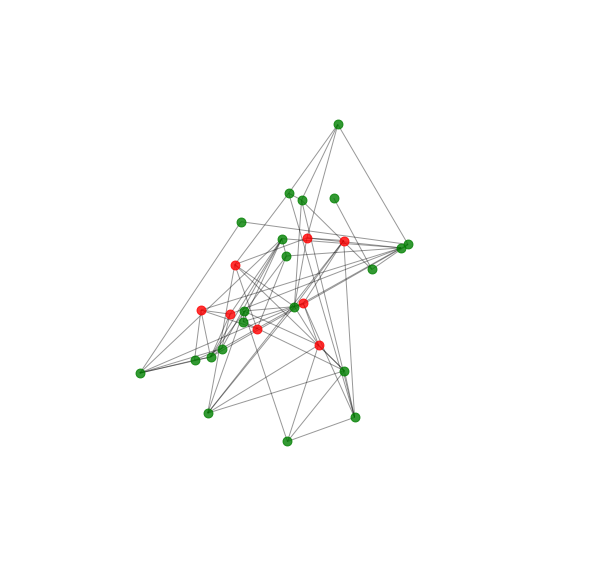

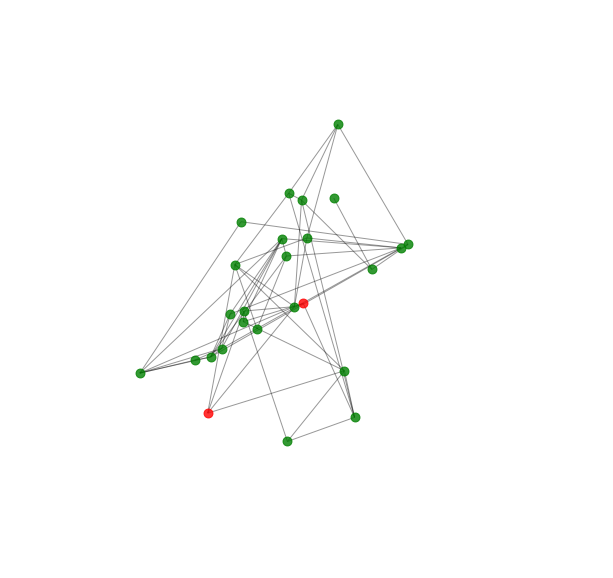

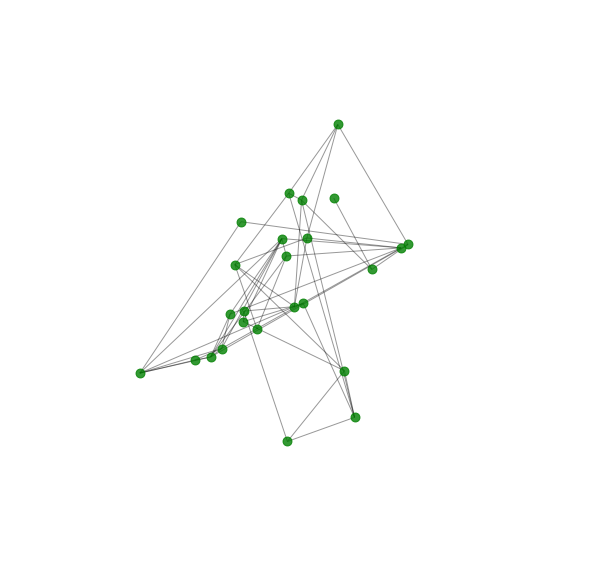

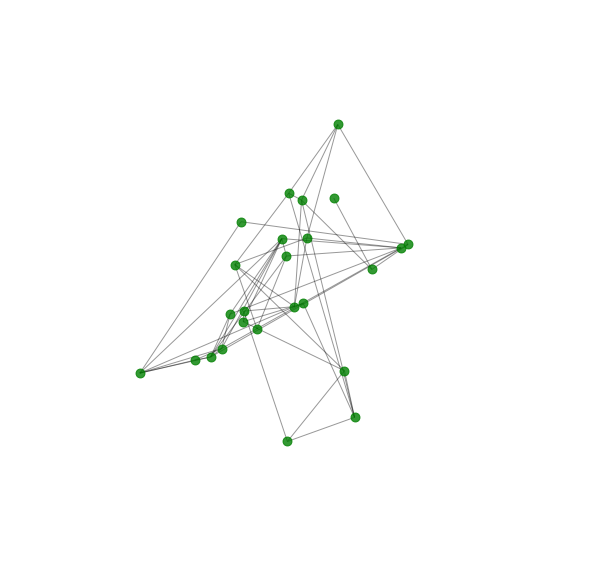

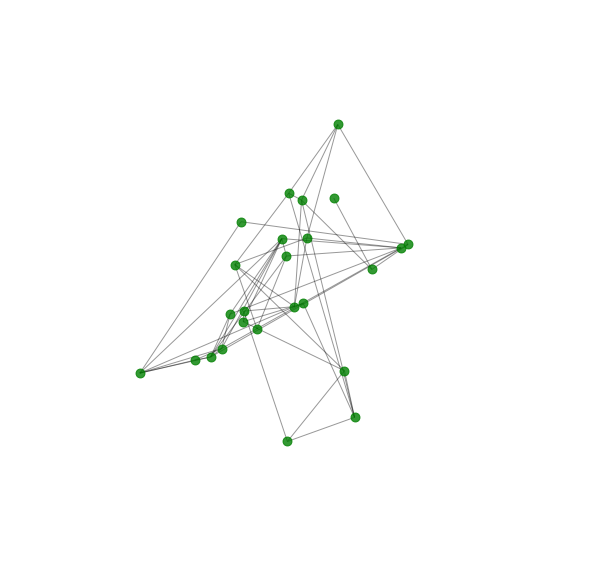

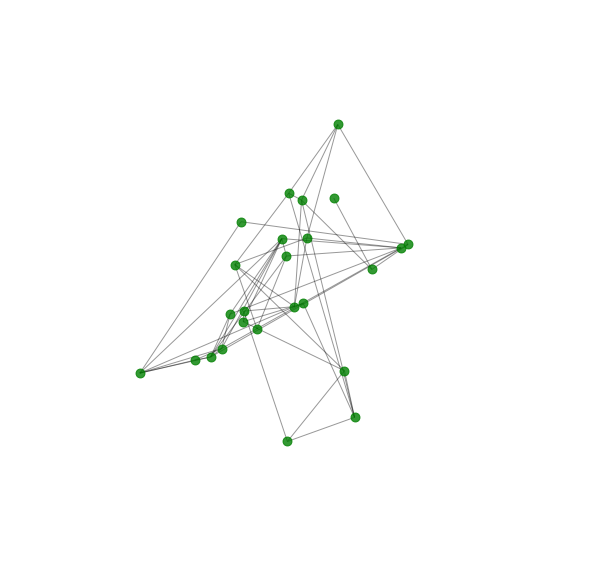

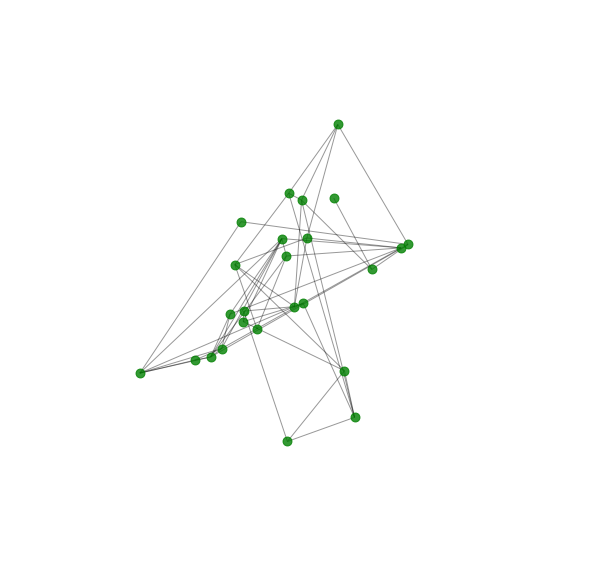

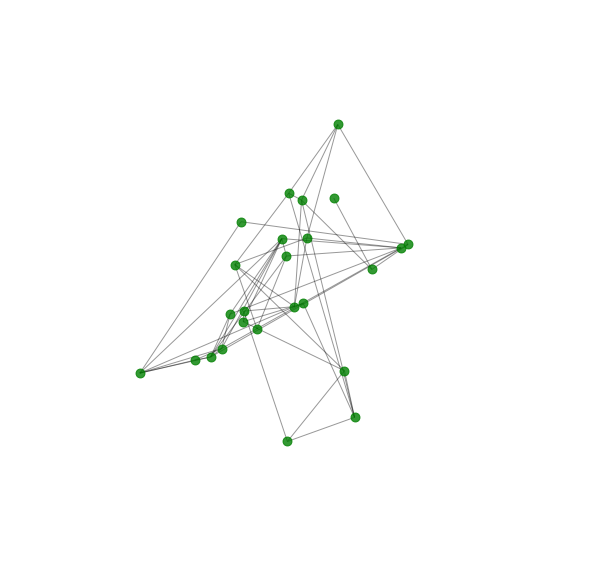

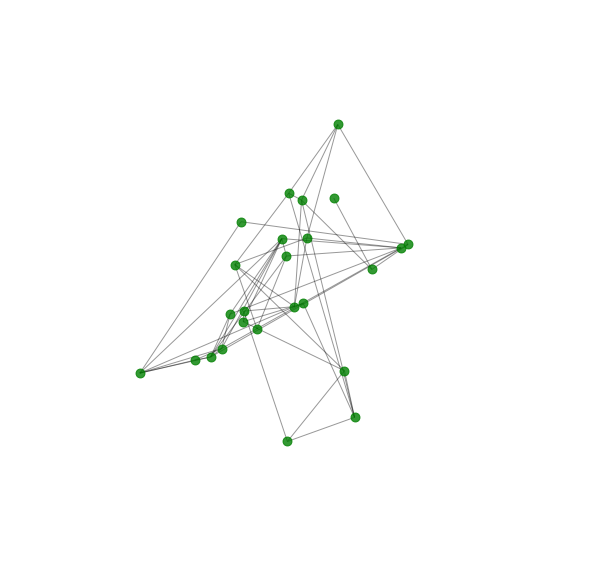

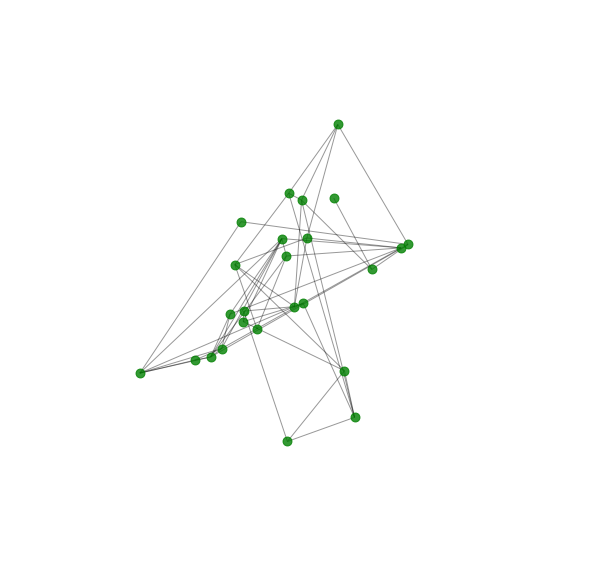

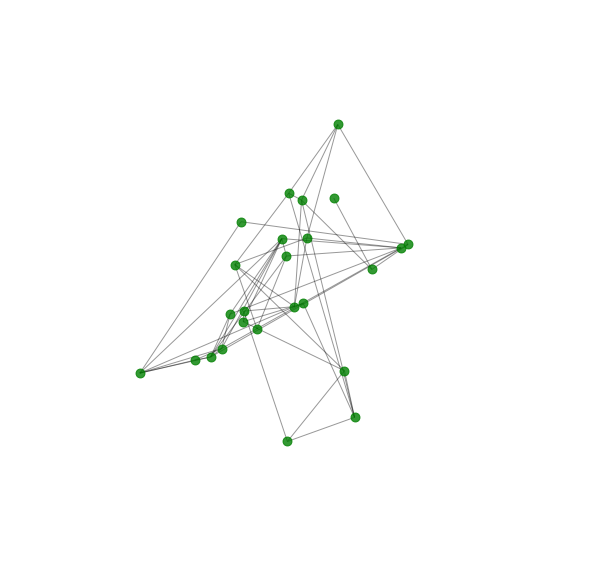

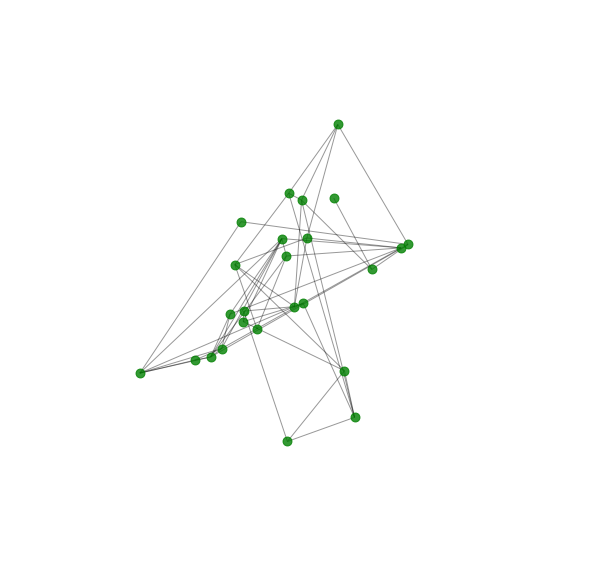

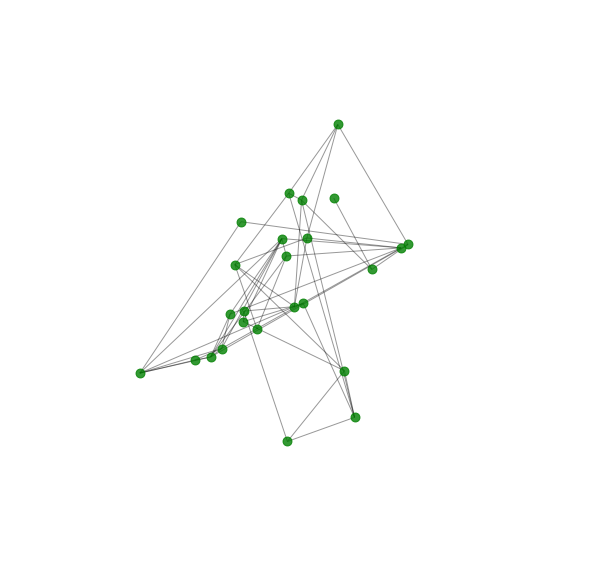

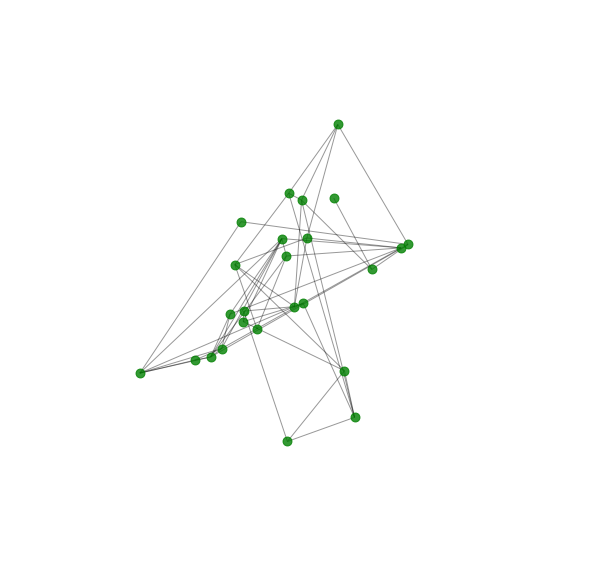

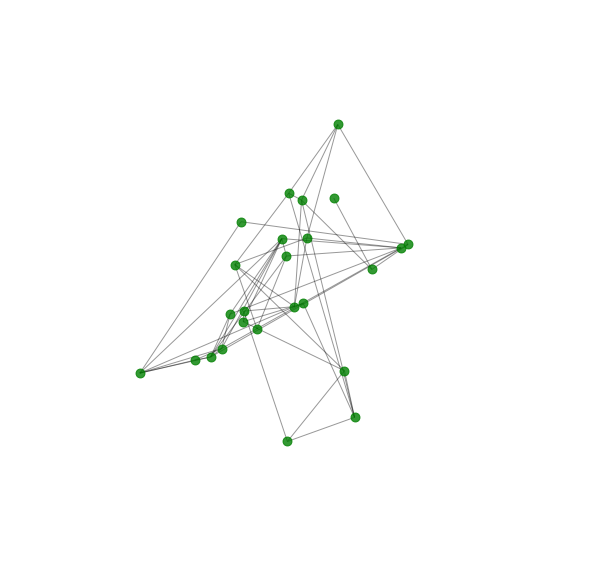

In [87]:
#Demande du temps d'etude

t = int(input('Temps t : '))

M = nx.get_node_attributes(G3, 'malade')
Pop_malade_0 = len([k for k,v in M.items() if v == 'Oui'])
Pop_tot = [n]
Pop_malade_t = [Pop_malade_0]
Pop_saine = [n-Pop_malade_0]
Pop_retablie = [0]
Temps = [0]

for j in range(t):
    transmission_maladie(G3, lmbda)
    deces_guerison (G3, eta, Pop_retablie,rho,Pop_tot)
    temps_malade(G3,Pop_malade_t,Pop_saine)
    representation_reseau(G3, pos2)
    Temps.append(j+1)

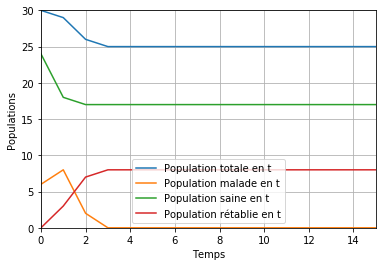

In [88]:
# Graphique représentant les différentes populations en t pour une maladie et un taux de couverture donné

x = np.array(Temps)
y1 = np.array(Pop_tot)
y2 = np.array(Pop_malade_t)
y3 = np.array(Pop_saine)
y4 = np.cumsum(Pop_retablie)
plt.plot(x, y1, label="Population totale en t")
plt.plot(x, y2, label="Population malade en t")
plt.plot(x, y3, label="Population saine en t")
plt.plot(x, y4, label="Population rétablie en t")

#Légendes sur les axes
plt.xlabel("Temps")
plt.ylabel("Populations")

# Limites du graphique
plt.axis([0, max(Temps), 0, max(Pop_tot)])

plt.grid(True)
plt.legend()
plt.show()

### Taux de vaccination idéale pour une maladie donnée



In [94]:
# Création de la liste des taux de vaccination possibles
range_mu = [i/100 for i in range(101)]

range_mu_20 = [i/20 for i in range(21)]

range_mu_simple = [i/10 for i in range(11)]

# On choisira range_mu_20

In [98]:
# Les caractéristiques de la maladie
lmbda = float(input('Contagiosité de la maladie : '))
eta = float(input('Probabilité que la personne guérisse sans vaccin : '))
rho = float(input('Probabilité de deces suite a la maladie : '))

# Autres paramètres
p_init = float(input ('Pourcentage initial de personnes contaminées : ')) # Convention à 0.05 ?
t = int(input('Le nombre de Temps t que dure l épidémie : ')) # Convention à 20 ? 

# On suppose que l'on a un réseau G2, ce sera le même réseau de base tout du long du test.

# Initialisation de la récolte statistique
pourcent_morts = [] # le % de morts en moyenne après une épidémie d'une maladie donnée en fonction du taux de vaccination
pourcent_malades = [] # le % de personnes tombées malades en moyenne au cours d'une épidémie d'une maladie donnée en fonction du taux de vaccination

for mu in range_mu_20: # ou alors "range_mu" ou range_mu_simple
    
    # Initialisation de la récolte statistiques intermédiaire
    pourcent_morts_mu = [] # pour un mu donné, c'est la liste des résultats des 10 tests effectués avec le même mu
    pourcent_malades_mu = [] # pour un mu donné, c'est la liste des résultats des 10 tests effectués avec le même mu
    
    for i in range(10):
        
        #réinitialiser le réseau
        G3 = nx.Graph.copy(G2)
        
        #Création d'une populations
        Populations = {k: {'malade': np.random.choice(["Oui", "Non"], p=[p_init, 1-p_init]), 'vacciné': np.random.choice(["Oui", "Non"], p=[mu, 1-mu]), 'temps malade': 0} for k in range(len(G2.nodes()))}
        # Attention au "range(n)" de Populations ==> faire en sorte que ce soit bien le même n qui a créé le réseau que l'on utilise
        # Pour que les malades à l'origine ait 'temps malade' = 1 dès le début du processus"
        for k in range(n):
            if Populations[k]['malade'] == 'Oui':
                Populations[k]['temps malade'] += 1
        #Fin de la modification
        
        #Application des caractéristiques de la nouvelle population au réseau qui, lui, reste constant
        nx.set_node_attributes(G3,Populations)
        
        # processus dynamique
        M = nx.get_node_attributes(G3, 'malade')
        Pop_malade_0 = len([k for k,v in M.items() if v == 'Oui'])
        Pop_tot = [n]
        Pop_malade_t = [Pop_malade_0]
        Pop_saine = [n-Pop_malade_0]
        Pop_retablie = [0]
        Temps = [0]

        for j in range(t):
            transmission_maladie(G3, lmbda)
            deces_guerison (G3, eta, Pop_retablie,rho,Pop_tot)
            temps_malade(G3,Pop_malade_t,Pop_saine)
            Temps.append(j+1)
            
    # Mise à jour des statistiques : récolte de l'information sur le nombre de malades totales au cours de l'épidémie
    # On récolte aussi le nombre de morts au cours de l'épidémie
        pourcent_morts_mu.append((len(G2.nodes())-len(G3.nodes()))/len(G2.nodes()))
        pourcent_malades_mu.append((len(G2.nodes())-Pop_saine[t-1])/len(G2.nodes()))
        
    pourcent_morts.append(sum(pourcent_morts_mu)/len(pourcent_morts_mu))
    pourcent_malades.append(sum(pourcent_malades_mu)/len(pourcent_malades_mu))
    
# Temps du programme : pour une population de 1000 et range_mu_simple, ce programme prend 3 minutes à éxecuter.

Contagiosité de la maladie : 0.5
Probabilité que la personne guérisse sans vaccin : 0.8
Probabilité de deces suite a la maladie : 0.01
Pourcentage initial de personnes contaminées : 0.02
Le nombre de Temps t que dure l épidémie : 15


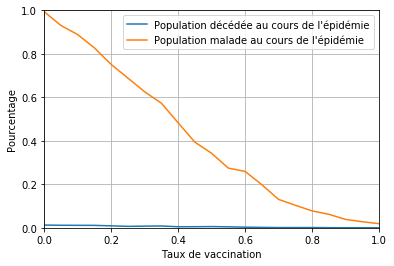

In [99]:
# Création du graphique : % de morts et % de malades au cours d'une épidémie d'une maladie donnée en fonction du taux de vaccination

x = np.array(range_mu_20) # ou "range_mu"
y1 = np.array(pourcent_morts)
y2 = np.array(pourcent_malades)
plt.plot(x, y1, label="Population décédée au cours de l'épidémie")
plt.plot(x, y2, label="Population malade au cours de l'épidémie")

#Légendes sur les axes
plt.xlabel("Taux de vaccination")
plt.ylabel("Pourcentage")

# Limites du graphique
plt.axis([0.0, 1.0, 0.0, 1.0])

plt.grid(True)
plt.legend()
plt.show()

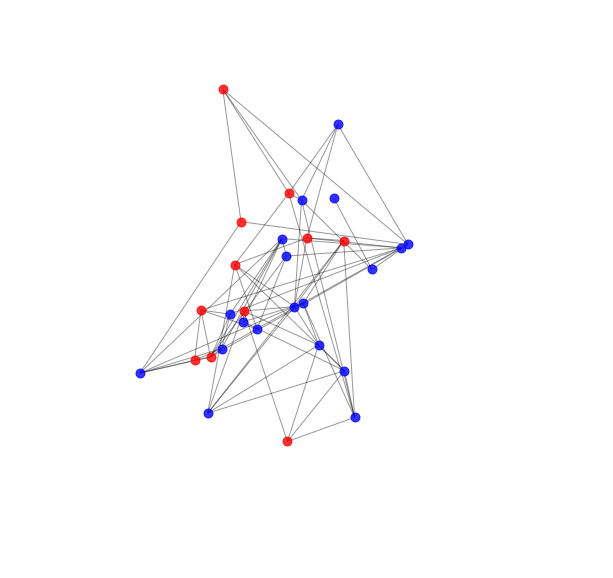

In [75]:
#GRAPHE POSSIBLE AUSSI INITIAL : voir les personnes vaccinés initialement dans le réseau
plt.figure(figsize=(10, 10))

# Représentation des listes de noeuds
nx.draw_networkx_nodes(G3, pos2, nodelist= Noeuds_vaccines, node_color='b',node_size=80, alpha=0.8)
nx.draw_networkx_nodes(G3, pos2, nodelist= Noeuds_pas_vaccines, node_color='r', node_size=80, alpha=0.8)


# Représentation des liens
nx.draw_networkx_edges(G3, pos2, alpha=0.4)

#Affichage du graphe
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.axis('off')
plt.show()

### Pistes d'amélioration

-Faire en sorte que au moment initial, les individus ne soient pas malades s'ils sont vaccinés
-Faire un truc plus concis pour la création de génération
-Présenter le graphe plus joliment
-Pour Dupré : Trouver un autre moyen pour créer le réseau